In [1]:
import tensorflow as tf
import numpy as np

from tensorflow import keras

In [12]:
import os

In [4]:
import random
import PIL

from keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
from keras.models import Model, load_model
from keras.layers import Input, Activation, BatchNormalization
from keras.layers.convolutional import Conv2D, Conv2DTranspose, SeparableConv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import ModelCheckpoint
#from keras.optimizers import Adam

from skimage.transform import resize
from IPython.display import Image, display
from PIL import Image, ImageOps

In [5]:
class FESB_MLID(keras.utils.Sequence):
    """ Helper to iterate over the data (as Numpy arrays). """

    def __init__(self, batch_size, img_width, img_height, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_width = img_width
        self.img_height = img_height
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """ Returns tuple (input, target) correspond to batch #idx. """

        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]

        X = np.zeros((self.batch_size, img_height,
                      img_width, 3), dtype=np.float32)
        for image_index, path in enumerate(batch_input_img_paths):
            img = load_img(path)
            x_img = img_to_array(img)
            x_img = resize(x_img, (img_height, img_width, 3), mode='constant')
            X[image_index] = x_img / 255

        y = np.zeros((self.batch_size, img_height,
                      img_width, 3), dtype=np.float32)
        for target_index, path in enumerate(batch_target_img_paths):
            target_img = img_to_array(load_img(path))
            target_img = resize(
                target_img, (img_height, img_width, 3), mode='constant')
            y[target_index] = target_img / 255

        return X, y

In [6]:
def conv2d_block(input_tensor, n_filters, kernel_size=3):
    # first layer
    x = SeparableConv2D(filters=n_filters, kernel_size=(
        kernel_size, kernel_size), padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # second layer
    x = SeparableConv2D(filters=n_filters, kernel_size=(
        kernel_size, kernel_size), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    # third layer
    x = SeparableConv2D(filters=n_filters, kernel_size=(
        kernel_size, kernel_size), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

In [7]:
def get_model(input_img, n_filters=16):
    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3)
    p1 = MaxPooling2D((2, 2))(c1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3)
    p2 = MaxPooling2D((2, 2))(c2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3)
    p3 = MaxPooling2D((2, 2))(c3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)

    c5 = conv2d_block(p4, n_filters=n_filters*16, kernel_size=3)
    p5 = MaxPooling2D(pool_size=(2, 2))(c5)

    c6 = conv2d_block(p5, n_filters=n_filters*32, kernel_size=3)

    # expansive path

    u7 = Conv2DTranspose(n_filters*16, (3, 3),
                         strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c5])
    c7 = conv2d_block(u7, n_filters=n_filters*8, kernel_size=3)

    u8 = Conv2DTranspose(n_filters*8, (3, 3),
                         strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c4])
    c8 = conv2d_block(u8, n_filters=n_filters*8, kernel_size=3)

    u9 = Conv2DTranspose(n_filters*4, (3, 3),
                         strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c3])
    c9 = conv2d_block(u9, n_filters=n_filters*4, kernel_size=3)

    u10 = Conv2DTranspose(n_filters*2, (3, 3),
                          strides=(2, 2), padding='same')(c9)
    u10 = concatenate([u10, c2])
    c10 = conv2d_block(u10, n_filters=n_filters*2, kernel_size=3)

    u11 = Conv2DTranspose(n_filters*1, (3, 3),
                          strides=(2, 2), padding='same')(c10)
    u11 = concatenate([u11, c1], axis=3)
    c11 = conv2d_block(u11, n_filters=n_filters*1, kernel_size=3)

    outputs = Conv2D(3, (1, 1), activation='softmax')(c11)
    model = Model(inputs=[input_img], outputs=[outputs])

    return model

In [8]:
def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(
        keras.preprocessing.image.array_to_img(mask))
    display(img)

In [9]:
input_dir = "/Users/veronika/Documents/FESB_MLID/images"
target_dir = "/Users/veronika/Documents/FESB_MLID/masks"

In [10]:
    img_width = 512
    img_height = 512
    batch_size = 10

In [13]:
    input_img_paths = sorted(
        [
            os.path.join(input_dir, fname)
            for fname in os.listdir(input_dir)
            if fname.endswith(".jpg")
        ]
    )

In [14]:
    target_img_paths = sorted(
        [
            os.path.join(target_dir, fname)
            for fname in os.listdir(target_dir)
            if fname.endswith(".bmp") and not fname.startswith(".")
        ]
    )

Images and their masks:
/Users/veronika/Documents/FESB_MLID/images/src_1.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_1.bmp
/Users/veronika/Documents/FESB_MLID/images/src_10.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_10.bmp
/Users/veronika/Documents/FESB_MLID/images/src_100.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_100.bmp
/Users/veronika/Documents/FESB_MLID/images/src_101.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_101.bmp
/Users/veronika/Documents/FESB_MLID/images/src_102.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_102.bmp
/Users/veronika/Documents/FESB_MLID/images/src_103.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_103.bmp
/Users/veronika/Documents/FESB_MLID/images/src_104.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_104.bmp
/Users/veronika/Documents/FESB_MLID/images/src_105.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_105.bmp
/Users/veronika/Documents/FESB_MLID/images/src_106.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_

/Users/veronika/Documents/FESB_MLID/images/src_58.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_58.bmp
/Users/veronika/Documents/FESB_MLID/images/src_59.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_59.bmp
/Users/veronika/Documents/FESB_MLID/images/src_6.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_6.bmp
/Users/veronika/Documents/FESB_MLID/images/src_60.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_60.bmp
/Users/veronika/Documents/FESB_MLID/images/src_61.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_61.bmp
/Users/veronika/Documents/FESB_MLID/images/src_62.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_62.bmp
/Users/veronika/Documents/FESB_MLID/images/src_63.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_63.bmp
/Users/veronika/Documents/FESB_MLID/images/src_64.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_64.bmp
/Users/veronika/Documents/FESB_MLID/images/src_65.jpg | /Users/veronika/Documents/FESB_MLID/masks/gt_65.bmp
/Users/veronika/Documents/FESB

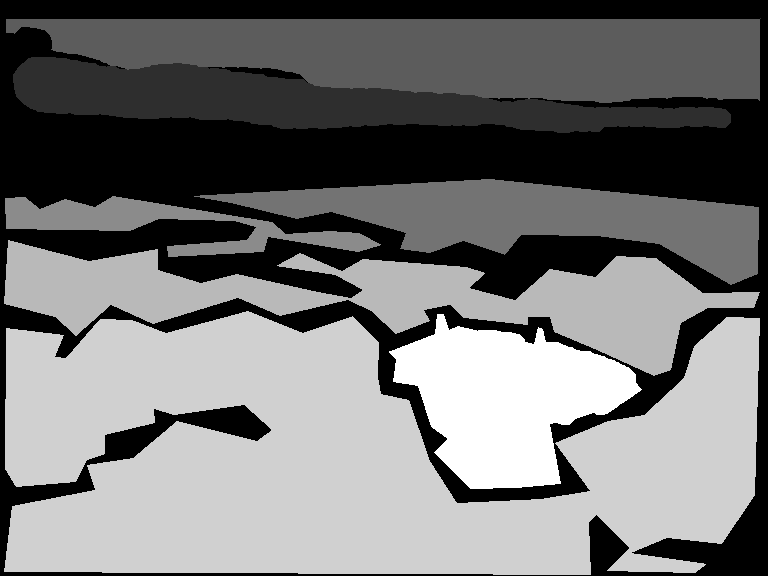

In [15]:
    print("Images and their masks:")
    for input_path, target_path in zip(input_img_paths, target_img_paths):
        print(input_path, "|", target_path)

    img = PIL.ImageOps.autocontrast(load_img(target_img_paths[399]))
    display(img)

In [16]:
    val_samples = 40
    random.Random(1337).shuffle(input_img_paths)
    random.Random(1337).shuffle(target_img_paths)

In [19]:
input_img = Input((img_height, img_width, 3), name='img')
model = get_model(input_img, n_filters = 16)

In [21]:
    val_input_img_paths = input_img_paths[-val_samples:]
    val_target_img_paths = target_img_paths[-val_samples:]

In [22]:
val_gen = FESB_MLID(batch_size, img_width, img_height,
val_input_img_paths, val_target_img_paths)

In [24]:
model.compile(optimizer="rmsprop", loss="binary_crossentropy",
                  metrics=["accuracy"])

print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
separable_conv2d (SeparableConv (None, 512, 512, 16) 91          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 512, 512, 16) 64          separable_conv2d[0][0]           
__________________________________________________________________________________________________
activation (Activation)         (None, 512, 512, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [25]:
loss, acc = model.evaluate(val_gen,verbose=2)
print("Untrained model, accuracy: {:5.2f}%".format(100 * acc))

4/4 - 36s - loss: 0.6931 - accuracy: 0.0044
Untrained model, accuracy:  0.44%


In [27]:
print("SHOWING AN IMAGE:")
with Image.open('/Users/veronika/Documents/FESB_MLID/images/src_1.jpg') as img:
   img.show()

print("SHOWING A MASK:")
with Image.open('/Users/veronika/Documents/FESB_MLID/masks/gt_1.bmp') as img:
   img.show()

SHOWING AN IMAGE:
SHOWING A MASK:


In [28]:
model.load_weights("/Users/veronika/Documents/probe/model-proba5-3.h5")

In [29]:
val_preds = model.predict(val_gen)

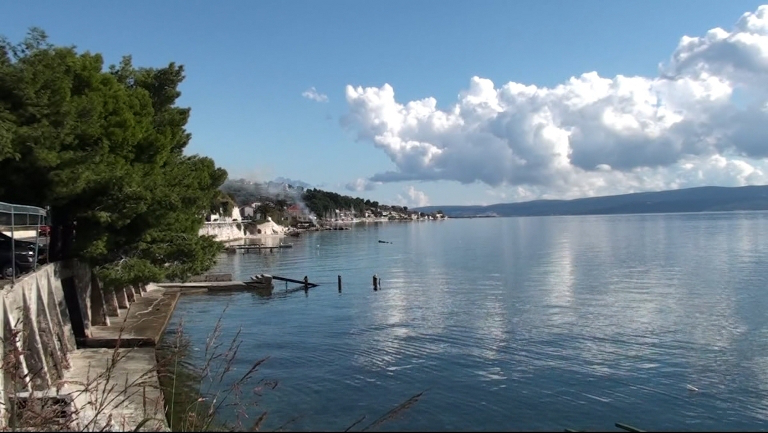

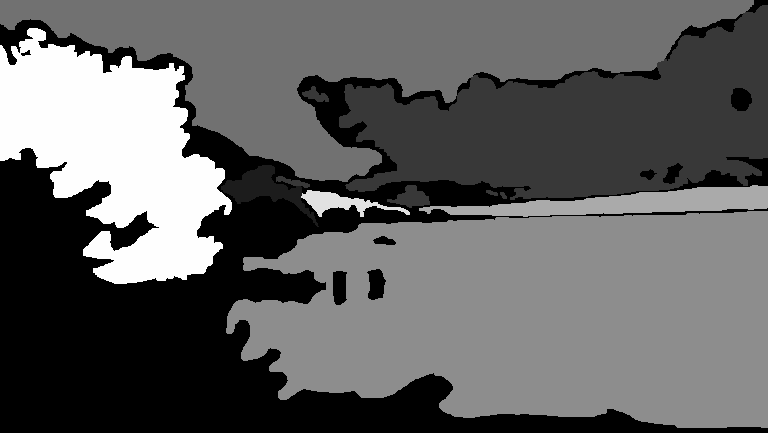

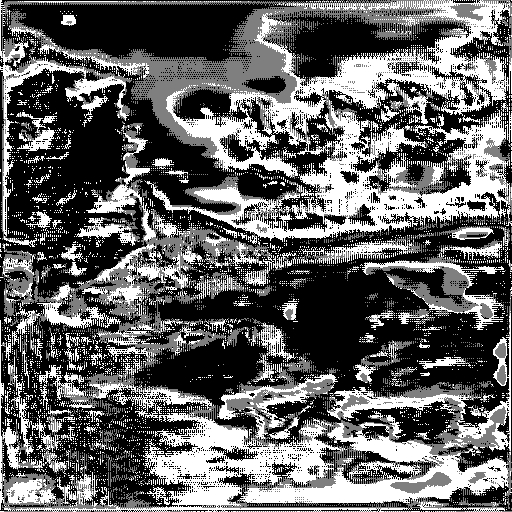

In [37]:
i = 19

# Display input image
display(Image.open(val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

    # Display mask predicted by our model
display_mask(i)

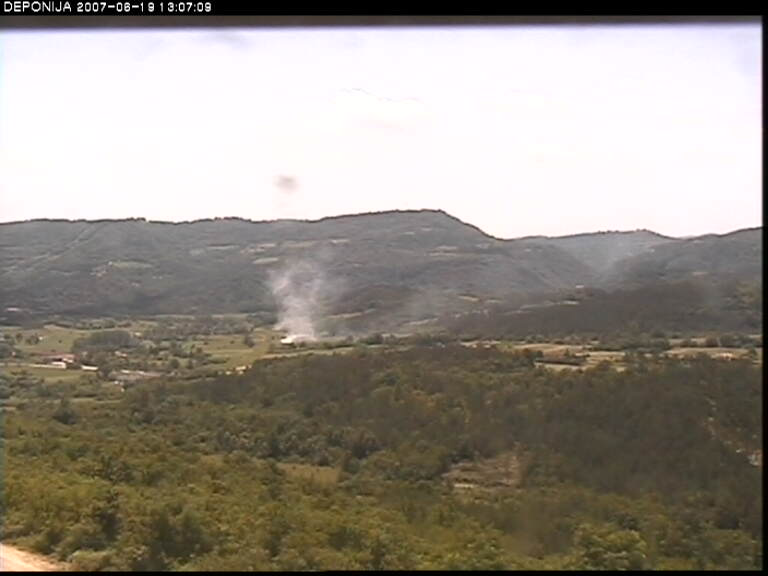

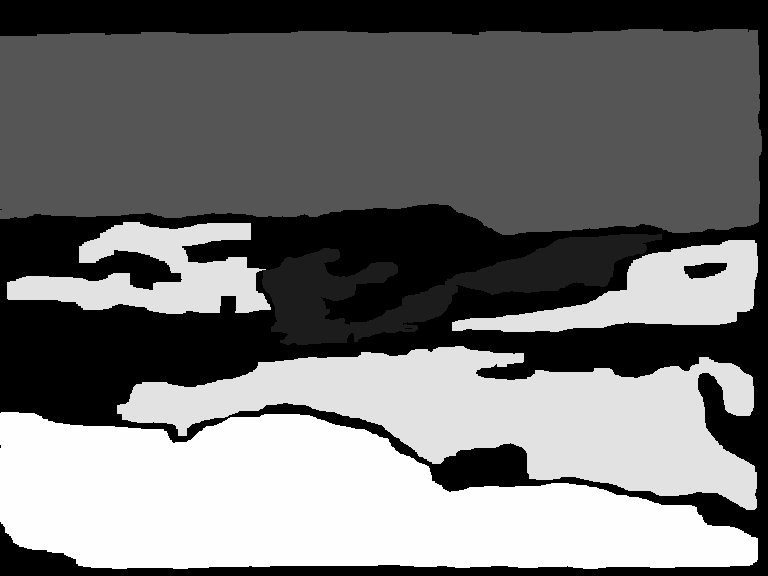

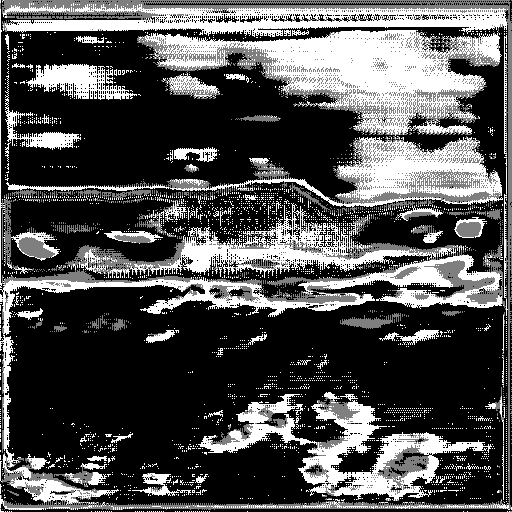

In [38]:
i = 39

# Display input image
display(Image.open(val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

    # Display mask predicted by our model
display_mask(i)

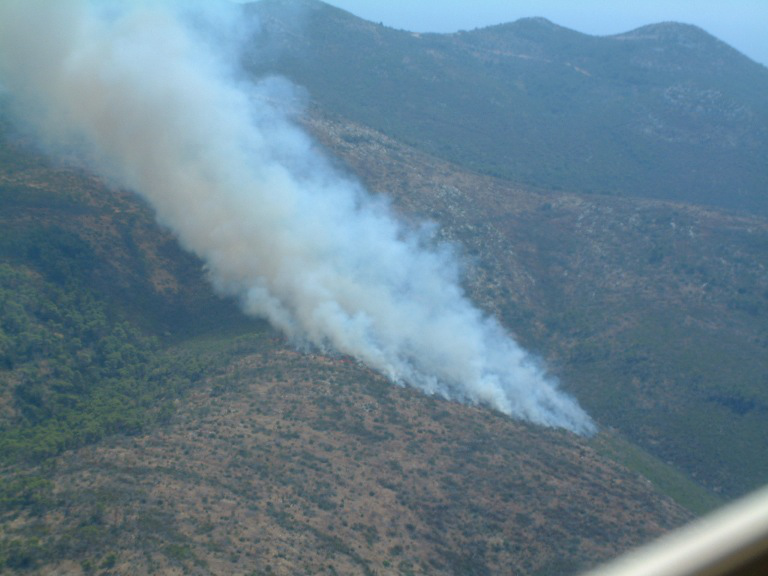

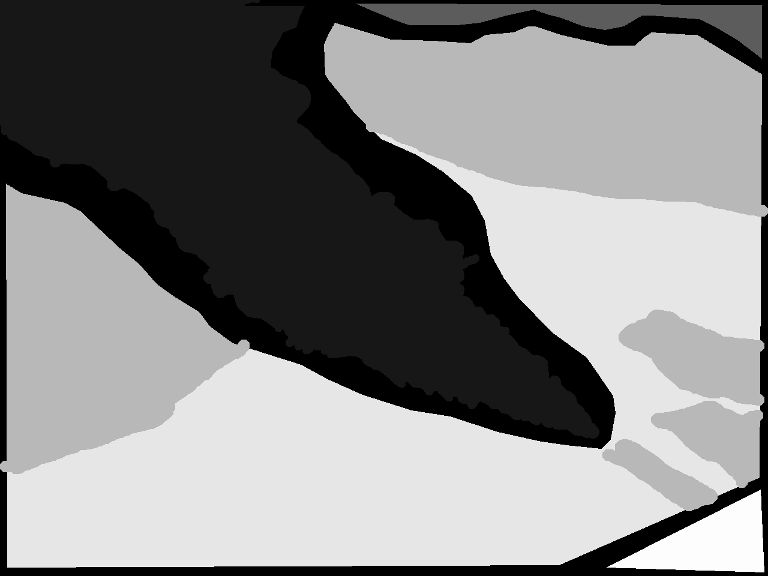

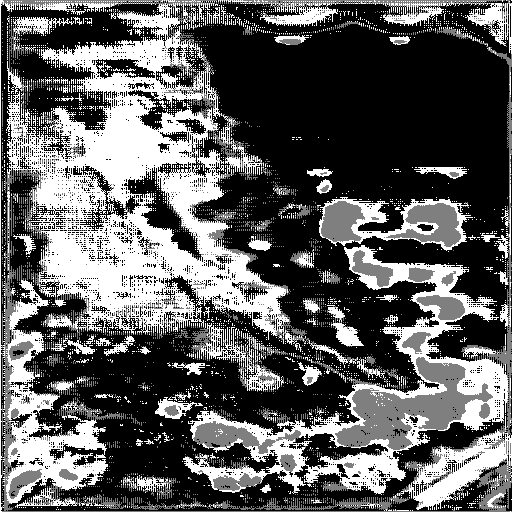

In [39]:
i = 1

# Display input image
display(Image.open(val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

    # Display mask predicted by our model
display_mask(i)